# Convolutional Neural Network 모델 정의

In [2]:
import torch
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
CPU = "cpu"
print(DEVICE, CPU)

cuda cpu


In [7]:
layer = nn.Conv2d(in_channels=4,        # 입력 채널 수
                    out_channels=2,     # 출력 채널 수
                    kernel_size=3,      # 커널 크기 (3, 3) == 3
                    stride=1,           # 스트라이드 (1, 1) == 1 default = 1
                    padding=0,          # 패딩 (1, 1) == 1 default = 0
                    )
print(layer)

Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1))


In [8]:
# layer.weight / layer.bias => layer의 파라미터
layer.weight.shape
# [2, 4, 3, 3] -> [out_channels, -> 필터의 갯수 
#                  in_channels,  -> 입력 채널 수
#                  kernel_size,  -> 커널 크기(height)
#                  kernel_size  -> 커널 크기(width)
#                 ]

torch.Size([2, 4, 3, 3])

In [9]:
layer.bias
# [2] -> [out_channels]

Parameter containing:
tensor([ 0.1146, -0.1394], requires_grad=True)

In [15]:
input_data =  torch.ones(1, 4, 3, 3) # 데이터의 갯수: 1, ch:3, h:3, w:3

In [20]:
ch1 = torch.sum(input_data[0, 0] * layer.weight[0, 0])
ch2 = torch.sum(input_data[0, 1] * layer.weight[0, 1])
ch3 = torch.sum(input_data[0, 2] * layer.weight[0, 2])
ch4 = torch.sum(input_data[0, 3] * layer.weight[0, 3])

result = ch1 + ch2 + ch3 + ch4 + layer.bias[0].item()

ch1 = torch.sum(input_data[0, 0] * layer.weight[1, 0])
ch2 = torch.sum(input_data[0, 1] * layer.weight[1, 1])
ch3 = torch.sum(input_data[0, 2] * layer.weight[1, 2])
ch4 = torch.sum(input_data[0, 3] * layer.weight[1, 3])

result2 = ch1 + ch2 + ch3 + ch4 + layer.bias[1].item()

result, result2

(tensor(-0.2505, grad_fn=<AddBackward0>),
 tensor(0.0274, grad_fn=<AddBackward0>))

In [21]:
result3 = layer(input_data)
result3

tensor([[[[-0.2505]],

         [[ 0.0274]]]], grad_fn=<ConvolutionBackward0>)

# MNIST

In [47]:
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms
from torchinfo import summary
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.train import fit

import matplotlib.pyplot as plt
import numpy as np

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
CPU = 'cpu'

In [48]:
DATASET_ROOT_PATH =  'datasets'
MODEL_SAVE_PATH = 'models'

N_EPOCH = 1
BATCH_SIZE = 128
LR = 0.001

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"

## Data 준비

In [49]:
train_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, is_train=True)
test_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, is_train=False)

In [50]:
train_loader.dataset, test_loader.dataset

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: datasets
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: datasets
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

## CNN 모델 정의

In [51]:
# CNN 모델 정의
#   Conv Layer: filter의 갯수(out channels)는 뒤로 갈수록 크게 한다.
#   출력결과 (Feature Map)의 크기는 점점 줄여나간다. => Max Pooling
# 1. Conv + ReLU + MaxPool
# 2. Conv + BatchNorm + ReLU + MaxPool
# 3. Conv + BatchNorm + ReLU + Dropout + MaxPool

class FMnistCNNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 3x3 필터, stride=1, padding=1 == output size = input size
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.3),
                                    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
                                    )
        
        self.block2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding='same'),       # padding='same' == padding=1
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.3),
                                    nn.MaxPool2d(kernel_size=2),                 # stride가 kernel_size와 같으면 stride 생략 가능
                                    )
        
        self.block3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding='same'),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.Dropout2d(0.3),
                                    nn.MaxPool2d(kernel_size=2),
                                    )
        
        self.output_block = nn.Sequential(
                                    nn.Flatten(),
                                    nn.Linear(128 * 3 * 3, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 10),
                                    )
        
        self.blocks = nn.Sequential(self.block1, self.block2, self.block3, self.output_block)
        
        
    def forward(self, X):
        
        out = self.blocks(X)
        
        return out

In [52]:
model = FMnistCNNModel().to(DEVICE)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FMnistCNNModel                           [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Sequential: 2-1                   [128, 32, 14, 14]         --
│    │    └─Conv2d: 3-1                  [128, 32, 28, 28]         320
│    │    └─BatchNorm2d: 3-2             [128, 32, 28, 28]         64
│    │    └─ReLU: 3-3                    [128, 32, 28, 28]         --
│    │    └─Dropout2d: 3-4               [128, 32, 28, 28]         --
│    │    └─MaxPool2d: 3-5               [128, 32, 14, 14]         --
│    └─Sequential: 2-2                   [128, 64, 7, 7]           --
│    │    └─Conv2d: 3-6                  [128, 64, 14, 14]         18,496
│    │    └─BatchNorm2d: 3-7             [128, 64, 14, 14]         128
│    │    └─ReLU: 3-8                    [128, 64, 14, 14]         --
│    │    └─Dropout2d: 3-9               [128, 64, 14, 14]         --
│    │   

In [56]:
next(iter(train_loader))[1].shape

torch.Size([128])

In [65]:
# 학습
import os

DATASET_ROOT_PATH =  './datasets'
SAVE_MODEL_PATH = './models/FashionMNIST/'
model_name = 'fashion_mnist_cnn_model.pth'
model_path = os.path.join(SAVE_MODEL_PATH, model_name)

N_EPOCH = 20
BATCH_SIZE = 1024
LR = 0.001

train_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, is_train=True)
test_loader = load_fashion_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, is_train=False)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"

model = FMnistCNNModel().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

rseult = fit(train_loader=train_loader, val_loader=test_loader, model=model, loss_fn=loss_fn, optimizer=optimizer,
            epochs=N_EPOCH, device=DEVICE, save_best_model=False, save_model_path=model_path,
            early_stopping=True, patience=10, mode='multi')

Epoch[1/20] - Train loss: 0.44708 Train Accucracy: 0.84173 || Validation Loss: 0.46354 Validation Accuracy: 0.83060
Epoch[2/20] - Train loss: 0.33610 Train Accucracy: 0.87803 || Validation Loss: 0.36526 Validation Accuracy: 0.86730
Epoch[3/20] - Train loss: 0.29339 Train Accucracy: 0.89125 || Validation Loss: 0.32747 Validation Accuracy: 0.88030
Epoch[4/20] - Train loss: 0.25862 Train Accucracy: 0.90257 || Validation Loss: 0.29573 Validation Accuracy: 0.89090
Epoch[5/20] - Train loss: 0.26159 Train Accucracy: 0.90213 || Validation Loss: 0.30256 Validation Accuracy: 0.88830
Epoch[6/20] - Train loss: 0.23251 Train Accucracy: 0.91338 || Validation Loss: 0.27391 Validation Accuracy: 0.89660
Epoch[7/20] - Train loss: 0.22308 Train Accucracy: 0.91763 || Validation Loss: 0.26748 Validation Accuracy: 0.90100
Epoch[8/20] - Train loss: 0.20848 Train Accucracy: 0.92248 || Validation Loss: 0.25504 Validation Accuracy: 0.90530
Epoch[9/20] - Train loss: 0.20366 Train Accucracy: 0.92528 || Validation

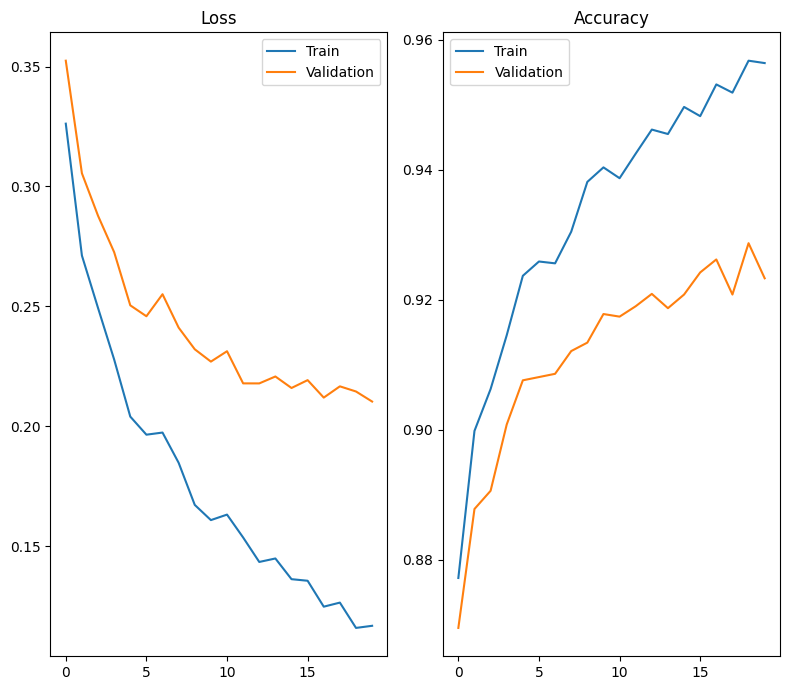

In [63]:
import module.utils as utils
utils.plot_fit_result(*rseult)
# batch_size = 128

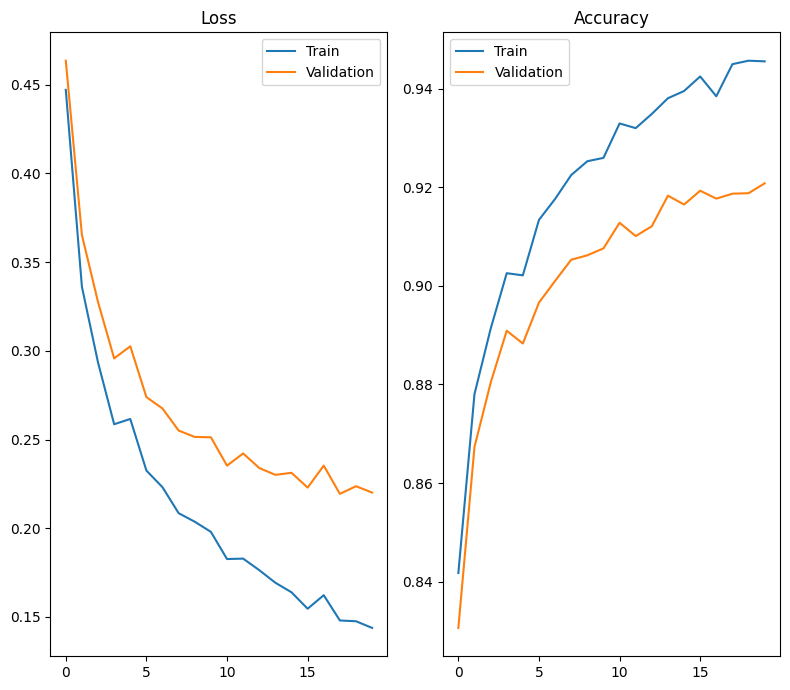

In [66]:
import module.utils as utils
utils.plot_fit_result(*rseult)
# batch_size = 1024

## Train